## 3.1 Variational autoencoder

[Auto-Encoding Variational Bayes (Kingma, Welling, 2013)](https://arxiv.org/abs/1312.6114)

Solution is based on [Oliver Dürr's](https://github.com/oduerr/dl_tutorial/tree/master/tensorflow/vae).

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Import the MNIST dataset in the same way as for the perceptron.

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


## Encoder

Create a placeholder called `x` for data minibatches of size 64. Then create two fully connected layers in the same way as for the classifier, but here in the last layer, instead of a softmax, we should map with a linear trainsformation into the parameters of the gaussian posterior. 

$$h_2(x)=\sigma\circ A_2\circ \sigma \circ A_1\circ x$$

$$\mu=A_{3m}\circ h_2(x)$$

$$\sigma_{pre}=A_{3v}\circ h_2(x)$$

These should for now be two `n_z` dimensional vector variables named `z_mean` and `z_sigma_pre`. Try `n_z = 2` and `n_h = 500` for the hidden layer widths.

In [3]:
n_z = 2 #Dimension of the latent space
n_h1 = 500
n_h2 = 500
batch_size = 64

# Input
x = tf.placeholder(tf.float32, shape=[None, 28*28]) 

# First hidden layer
W_1 = tf.Variable(tf.truncated_normal([784, n_h1], stddev=0.1))
b_1 = tf.Variable(tf.constant(0.1, shape=[n_h1]))
h_1 = tf.nn.sigmoid(tf.matmul(x, W_1) + b_1)

# Second hidden layer 
W_2 = tf.Variable(tf.truncated_normal([n_h1, n_h2], stddev=0.1))
b_2 = tf.Variable(tf.constant(0.1, shape=[n_h2]))
h_2 = tf.nn.sigmoid(tf.matmul(h_1, W_2) + b_2)

# Parameters for the Gaussian
W_3m = tf.Variable(tf.truncated_normal([n_h2, n_z], stddev=0.1))
b_3m = tf.Variable(tf.constant(0.1, shape=[n_z]))

mu = tf.add(tf.matmul(h_2, W_3m), b_3m)

W_3v = tf.Variable(tf.truncated_normal([n_h2, n_z], stddev=0.1))
b_3v = tf.Variable(tf.constant(0.1, shape=[n_z]))

sigma_pre = tf.add(tf.matmul(h_2, W_3v), b_3v)


Now define the sampling from the variational posterior, where we need to generate z samples for the whole minibatch. Generate an epsilon from a `tf.random_normal` with zero mean and unit variance, then:

$$z=\mu+\sqrt{e^{\sigma_{pre}}}\cdot \epsilon$$

In [4]:
eps = tf.random_normal((batch_size, n_z), 0, 1, dtype=tf.float32) 
z = tf.add(mu, tf.multiply(tf.sqrt(tf.exp(sigma_pre)), eps))

## Decoder

The generative model or decoder takes the latent $z$ values as inputs and generates datapoints from them. Define a two-layer fully connected network again to use as a generative model of digits. The last layer should map linearly into a vector of mean pixel values named `x_reconstr_mean`.

In [5]:
W_1g = tf.Variable(tf.truncated_normal([n_z, 500], stddev=0.1))
b_1g = tf.Variable(tf.constant(0.1, shape=[500]))
h_1g = tf.nn.sigmoid(tf.matmul(z, W_1g) + b_1g)

W_2g = tf.Variable(tf.truncated_normal([500, 501], stddev=0.1))
b_2g = tf.Variable(tf.constant(0.1, shape=[501]))
h_2g = tf.nn.sigmoid(tf.matmul(h_1g, W_2g) + b_2g)

W_3g = tf.Variable(tf.truncated_normal([501, 784], stddev=0.1))
b_3g = tf.Variable(tf.constant(0.1, shape=[784]))
x_reconstr_mean = tf.nn.sigmoid(tf.add(tf.matmul(h_2g, W_3g), b_3g))

## Loss function

The ELBO loss consists of the reconstruction and regularization terms. The first is the expected value of the log pdf of data conditioned on the inferred z value, the second is the kl divergence between the inferred posterior and the prior. The KL term can be calculated analytically for the case where both the prior and the posterior are gaussians.

In [6]:
reconstruction_cost = - tf.reduce_sum(x * tf.log(1e-10 + x_reconstr_mean) + (1-x) * tf.log(1e-10 + 1 - x_reconstr_mean), 1)

kl_cost = - 0.5 * tf.reduce_sum(1 + sigma_pre - tf.square(mu) - tf.exp(sigma_pre), 1)

cost = tf.reduce_mean(reconstruction_cost + kl_cost)

optimizer =  tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost)

## Training

This training will need a bit more time so I've provided a training code skeleton with a progress bar.

```
runs = 10
n_minibatches = int(mnist.train.num_examples / batch_size)

sess = tf.InteractiveSession()
init = tf.global_variables_initializer()
sess.run(init)

for epoch in range(runs):
    pbar = tf.contrib.keras.utils.Progbar(n_minibatches)
    for i in range(n_minibatches):
    
        #YOUR CODE HERE - update and calculate "cost_" on a minibatch
        
        pbar.add(1,[("cost",cost_)])
```

In [7]:
runs = 5
n_minibatches = int(mnist.train.num_examples / batch_size)

#saver = tf.train.Saver()
sess = tf.InteractiveSession()
init = tf.global_variables_initializer()
sess.run(init)

for epoch in range(runs):    
    pbar = tf.contrib.keras.utils.Progbar(n_minibatches)
    for i in range(n_minibatches):
        batch_xs, _ = mnist.train.next_batch(batch_size)
        _,cost_ = sess.run((optimizer, cost), feed_dict={x: batch_xs})
        pbar.add(1,[("avg cost",cost_)])
    print("\n")
    #saver.save(sess, "./model.ckpt")
print("final cost:",cost_)


859/859 [==============================] - 25s - avg cost: 193.8141    


858/859 [============================>.] - ETA: 0s - avg cost: 166.9594

859/859 [==============================] - 30s - avg cost: 159.4493    


858/859 [============================>.] - ETA: 0s - avg cost: 154.6534

859/859 [==============================] - 28s - avg cost: 151.3041    


final cost: 140.556


If you want to leave the training running for a longer while and save the resulting model for later analysis, you can load the tensorflow saver with `saver = tf.train.Saver()`, and save the current state with `saver.save(sess, "./model.ckpt")`. You can later restore the saved parameters with `saver.restore(sess, check_point_file)`.

## Load and analyse model

Plot some reconstructions. You can use the following code for a plot grid:
    
```
n_rec = 10
plt.figure(figsize=(n_rec+2,4))
for i in range(n_rec):
    plt.subplot(2, n_rec, i+1)
    
    #YOUR CODE HERE - plot command for samples
    
    plt.subplot(2, n_rec, n_rec+i+1)
    
    #YOUR CODE HERE - plot command for reconstructions
    
plt.tight_layout()
```

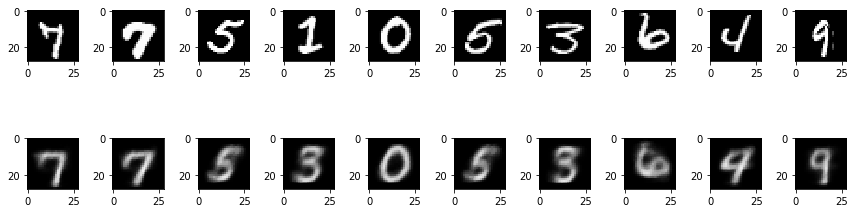

In [8]:
x_sample, _ = mnist.test.next_batch(batch_size)
x_reconstruct,z_vals = sess.run((x_reconstr_mean,z), feed_dict={x: x_sample})

n_rec = 10
plt.figure(figsize=(n_rec+2,4))
for i in range(n_rec):
    plt.subplot(2, n_rec, i+1)
    plt.imshow(x_sample[i].reshape(28, 28), vmin=0, vmax=1, interpolation='none',cmap=plt.get_cmap('gray'))
    plt.subplot(2, n_rec, n_rec+i+1)
    plt.imshow(x_reconstruct[i].reshape(28, 28), vmin=0, vmax=1, interpolation='none',cmap=plt.get_cmap('gray'))
plt.tight_layout()

Plot the z space embedding of the data.

(-4, 4)

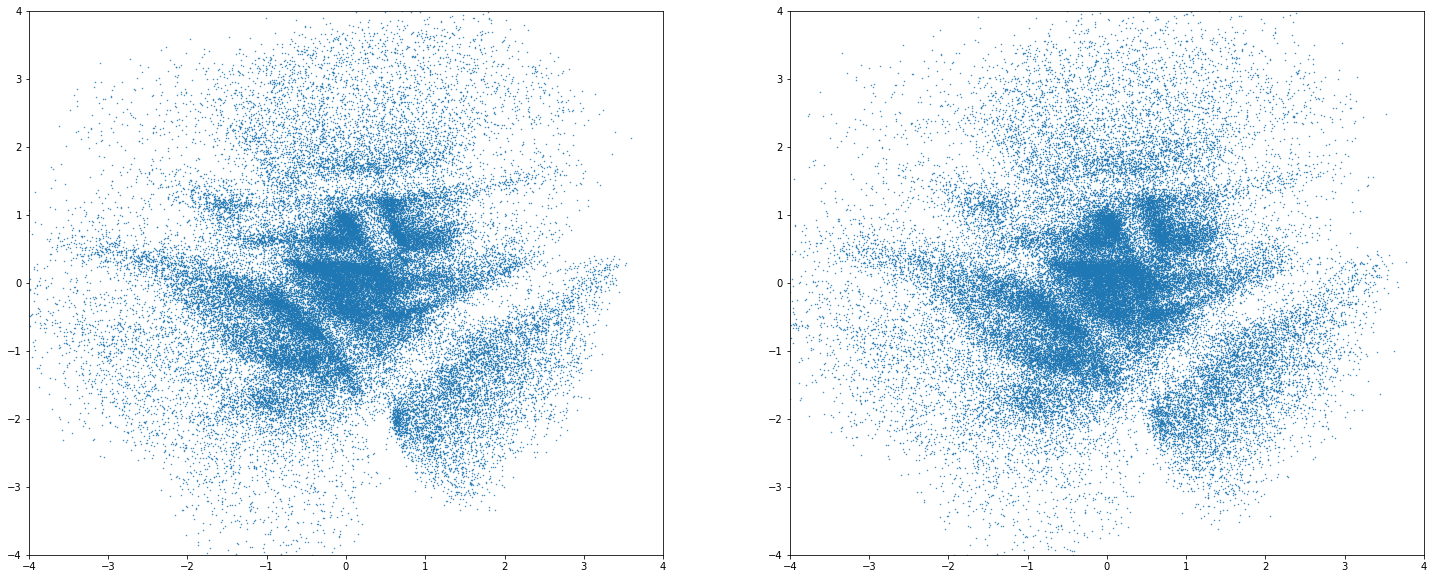

In [9]:
all_z_map = np.zeros((1,2))
all_z_samples = np.zeros((1,2))
n_minibatches = int(mnist.train.num_examples / batch_size)

for i in range(n_minibatches):
    batch_xs, _ = mnist.train.next_batch(batch_size)
    x_reconstruct,z_,mu_,sigma_pre_  = sess.run(
        (x_reconstr_mean, z, mu, sigma_pre), feed_dict={x: batch_xs})
    all_z_map = np.vstack((all_z_map, mu_))
    all_z_samples = np.vstack((all_z_samples, z_))
    
plt.close()
plt.figure(figsize=(25,10))

plt.subplot(1,2,1)
plt.scatter(*np.transpose(all_z_map), s=0.2)
plt.xlim(-4,4)
plt.ylim(-4,4)

plt.subplot(1,2,2)
plt.scatter(*np.transpose(all_z_samples), s=0.2)
plt.xlim(-4,4)
plt.ylim(-4,4)

Visualise the latent space by plotting images conditioned on a grid in $z$.

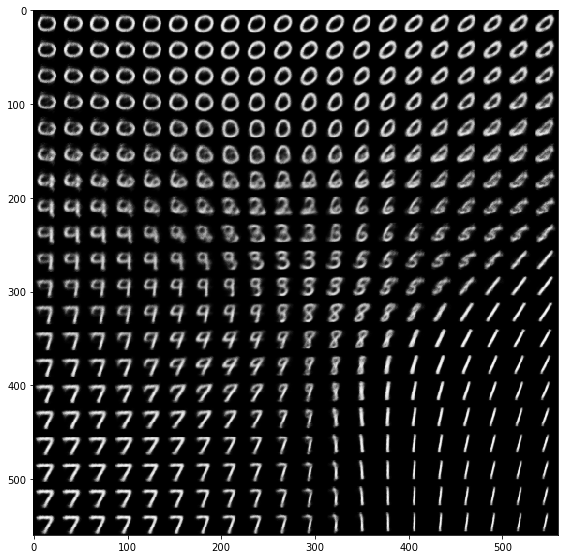

In [10]:
nx = ny = 20
x_values = np.linspace(-3, 3, nx)
y_values = np.linspace(-3, 3, ny)
canvas = np.empty((28*ny, 28*nx))

d = np.zeros([batch_size,2],dtype='float32')
d[0,] = [1,2]

for i, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
        z_mu = np.array([[xi, yi]])
        d[0] = z_mu
        x_mean = sess.run(x_reconstr_mean, feed_dict={z: d})
        canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = x_mean[0].reshape(28, 28)

plt.figure(figsize=(8, 10))        
Xi, Yi = np.meshgrid(x_values, y_values)
plt.imshow(canvas, origin="upper", vmin=0, vmax=1,interpolation='none',cmap=plt.get_cmap('gray'))
plt.tight_layout()

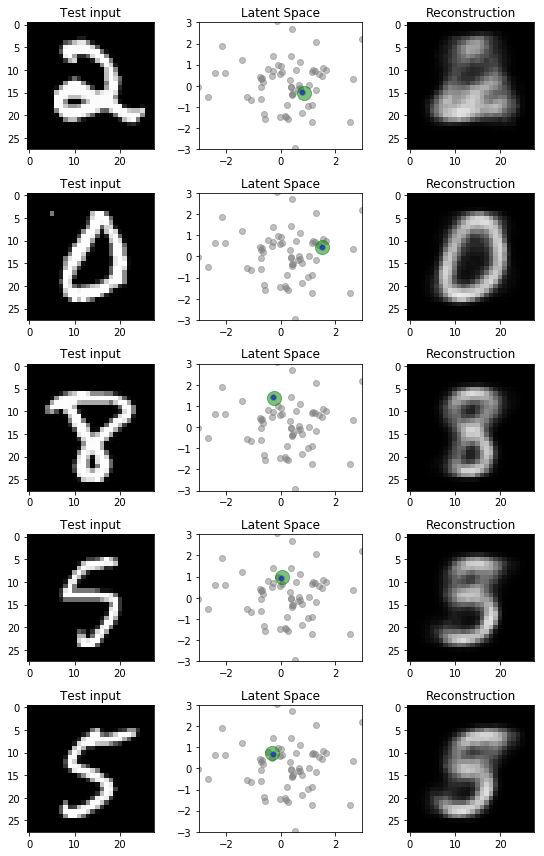

In [89]:
x_sample = mnist.test.next_batch(batch_size)[0]
x_reconstruct,z_vals,z_mean_val,z_log_sigma_sq_val  = sess.run((x_reconstr_mean,z, mu, sigma_pre), feed_dict={x: x_sample})

plt.figure(figsize=(8, 12))
for i in range(5):
    plt.subplot(5, 3, 3*i + 1)
    plt.imshow(x_sample[i].reshape(28, 28), vmin=0, vmax=1,  interpolation='none',cmap=plt.get_cmap('gray'))
    plt.title("Test input")

    plt.subplot(5, 3, 3*i + 2)
    plt.scatter(z_vals[:,0],z_vals[:,1], c='gray', alpha=0.5)
    plt.scatter(z_mean_val[i,0],z_mean_val[i,1], c='green', s=200, alpha=0.5)
    plt.scatter(z_vals[i,0],z_vals[i,1], c='blue', s=16, alpha=0.5)

    plt.xlim((-3,3))
    plt.ylim((-3,3))
    plt.title("Latent Space")

    plt.subplot(5, 3, 3*i + 3)
    plt.imshow(x_reconstruct[i].reshape(28, 28), vmin=0, vmax=1, interpolation='none',cmap=plt.get_cmap('gray'))
    plt.title("Reconstruction")
    #plt.colorbar()
plt.tight_layout()